# Gaussian Mixture Model and Likelihood Ratio Test with PyTorch

This notebook demonstrates the Maximum Likelihood Ratio (MLR) test using k-component Gaussian mixture models implemented in PyTorch. We'll explore:

1. **Null Distribution Generation**: Generate toy experiments under the null hypothesis
2. **Model Training**: Fit a flexible k-Gaussian mixture to observed data
3. **Test Statistic Computation**: Calculate 2log(LR) for hypothesis testing
4. **P-value Estimation**: Empirically estimate p-values using the null distribution

This exercise is a slightly adapted version taken from [NPLM-GOF](https://github.com/GaiaGrosso/NPLM-GOF/tree/main).

## 1. Import Required Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, chi2 
import torch
import torch.nn as nn

## 2. Define Gaussian Mixture Model Class

The `kGaussianModel` is a PyTorch neural network that computes the 2×log-likelihood ratio (2log(LR)) for a k-component Gaussian mixture model. 

**Key Formula:**
$$2\log(LR) = 2\log\left(\sum_{j=1}^{k} \frac{a_j}{\sigma_j\sqrt{2\pi}} \exp\left(-\frac{1}{2}\left(\frac{x-\mu_j}{\sigma_j}\right)^2\right)\right) - x^2$$

The model learns optimal means (μ) and standard deviations (σ) for each component, with fixed mixture amplitudes unless otherwise specified.

In [2]:
def prob_k_gaussian(x, mu_list, sigma_list, amplitude_list, device='cpu'):
    """
    Compute a mixture of k Gaussians using PyTorch.
    """
    # Convert inputs to tensors
    amplitude = torch.tensor(amplitude_list, dtype=torch.float32, device=device).view(1, -1)
    sigma     = torch.tensor(sigma_list, dtype=torch.float32, device=device).view(1, -1)
    mu        = torch.tensor(mu_list, dtype=torch.float32, device=device).view(1, -1)

    x = torch.tensor(x, dtype=torch.float32, device=device).view(-1, 1)

    # Softmax normalization
    norm_amp = torch.softmax(amplitude, dim=1)

    # Gaussian mixture
    coef = norm_amp / (torch.sqrt(torch.tensor(2*np.pi, dtype=torch.float32)) * sigma)
    expo = torch.exp(-0.5 * (x - mu)**2 / sigma**2)

    result = torch.sum(coef * expo, dim=1)
    return result.cpu().numpy()

class kGaussianModel(nn.Module):
    """
    PyTorch model for a k-component Gaussian mixture.
    Computes 2 * log-likelihood ratio test statistic.
    """
    def __init__(self, k,
                 mu0_list, sigma0_list, amplitude0_list,
                 train_mu=True, train_sigma=True, train_amplitude=False):
        super().__init__()

        if len(mu0_list) != k or len(sigma0_list) != k or len(amplitude0_list) != k:
            raise ValueError("List lengths must match k.")

        # Convert to parameters
        self.mu = nn.Parameter(
            torch.tensor(mu0_list, dtype=torch.float32).view(1, -1),
            requires_grad=train_mu
        )
        self.sigma = nn.Parameter(
            torch.tensor(sigma0_list, dtype=torch.float32).view(1, -1),
            requires_grad=train_sigma
        )
        self.amplitude = nn.Parameter(
            torch.tensor(amplitude0_list, dtype=torch.float32).view(1, -1) /
            np.sum(amplitude0_list),
            requires_grad=train_amplitude
        )

    def forward(self, x):
        """
        Compute 2 * log(LR).
        Input x must be shape [N] or [N,1].
        """
        if x.ndim == 1:
            x = x.view(-1, 1)

        # softmax mixture weights
        norm_amp = torch.softmax(self.amplitude, dim=1)

        # Compute likelihood-ratio term:
        #   exp(0.5 x^2 - 0.5 (x-mu)^2 / sigma^2) / sigma
        term = norm_amp / self.sigma * torch.exp(
            0.5 * x**2 - 0.5 * (x - self.mu)**2 / (self.sigma**2)
        )

        return 2 * torch.log(torch.sum(term, dim=1))


## 3. Define Loss Function and P-value Calculation

- **loss()**: Returns the negative sum of 2log(LR) predictions, used as the optimization objective
- **p_val_empirical()**: Computes empirical p-value as the fraction of null samples exceeding the observed test statistic

In [3]:
def loss(pred):
    return -torch.sum(pred)

def p_val_empirical(t_obs, t_ref):
    num = np.sum(t_ref > t_obs)
    return num / len(t_ref) if num > 0 else 1.0 / len(t_ref)


## 4. Generate Sample Data

We create three datasets:
- **Reference (Null)**: Standard normal N(0, 1)
- **Alternative 1**: Broader Gaussian N(0, 1.2)
- **Alternative 2**: Mixture of two Gaussians at ±0.83

In [4]:
# Configuration
seed = 1234
np.random.seed(seed)
N = 50  # Sample size

# Reference distribution (null hypothesis): N(0, 1)
mu0, std0 = 0, 1
reference = norm.rvs(loc=mu0, scale=std0, size=N)

# Alternative 1: Broader Gaussian N(0, 1.2)
mu1, std1 = 0, 1.2
data1 = norm.rvs(loc=mu1, scale=std1, size=N)

# Alternative 2: Mixture of two Gaussians at ±0.83, σ=0.5
mu2, std2 = 0.83, 0.5
data2 = np.append(
    norm.rvs(loc=mu2, scale=std2, size=int(N/2)), 
    norm.rvs(loc=-1*mu2, scale=std2, size=int(N/2))
)

print(f"Generated {N} samples for each dataset")

Generated 50 samples for each dataset


## 5. Training Helper Function

This function trains a k-Gaussian model and tracks parameter evolution during optimization. It records means, standard deviations, amplitudes, and loss at regular intervals.

In [5]:
def train_model_and_track(model, data, n_epochs=999, record_every=100, lr=1e-3, device='cpu'):
    """
    Train a PyTorch k-Gaussian model and track parameter evolution.
    """

    model = model.to(device)
    data = torch.tensor(data, dtype=torch.float32, device=device).view(-1, 1)

    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

    k = model.mu.shape[1]

    hist = {
        'mu': model.mu.detach().cpu().numpy().copy(),
        'sigma': model.sigma.detach().cpu().numpy().copy(),
        'amplitude': model.amplitude.detach().cpu().numpy().copy(),
        'loss': np.array([0.0])
    }

    for epoch in range(n_epochs):

        optimizer.zero_grad()

        pred = model(data)                   # model already outputs 2 log LR
        loss_value = -torch.sum(pred)        # consistent with previous fn

        loss_value.backward()
        optimizer.step()

        if epoch % record_every == 0:
            hist['mu'] = np.vstack([hist['mu'],
                                    model.mu.detach().cpu().numpy().reshape(1, -1)])
            hist['sigma'] = np.vstack([hist['sigma'],
                                       model.sigma.detach().cpu().numpy().reshape(1, -1)])
            hist['amplitude'] = np.vstack([hist['amplitude'],
                                           model.amplitude.detach().cpu().numpy().reshape(1, -1)])

            # recompute LL for visualization
            with torch.no_grad():
                pred_now = model(data)
                hist['loss'] = np.append(hist['loss'],
                                         (-torch.sum(pred_now)).item())

    # Ensure the final epoch snapshot is recorded (even if it didn't align with record_every)
    if (n_epochs - 1) % record_every != 0:
        hist['mu'] = np.vstack([hist['mu'], model.mu.detach().cpu().numpy().reshape(1, -1)])
        hist['sigma'] = np.vstack([hist['sigma'], model.sigma.detach().cpu().numpy().reshape(1, -1)])
        hist['amplitude'] = np.vstack([hist['amplitude'], model.amplitude.detach().cpu().numpy().reshape(1, -1)])
        with torch.no_grad():
            final_pred = model(data)
            hist['loss'] = np.append(hist['loss'], (-torch.sum(final_pred)).item())

    return hist


## 6. Visualization Function

Plots the evolution of model parameters and test statistic during training. Shows how means, standard deviations, and mixture amplitudes change as the model optimizes the likelihood ratio.

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def plot_training_history(hist, k, include_amplitude=False):
    
    n_plots = 4 if include_amplitude else 3
    fig, ax = plt.subplots(1, n_plots, figsize=(12*n_plots, 6))
    fig.patch.set_facecolor('white')

    # Means
    plt.subplot(1, n_plots, 1)
    for i in range(k):
        plt.plot(hist['mu'][:, i], lw=2, label=f'Gaussian {i+1}')
    plt.ylabel('μ (mean)', fontsize=22)
    plt.xlabel('Epochs (×100)', fontsize=22)
    plt.title('Mean Evolution', fontsize=20)
    if k <= 5:
        plt.legend()

    # Sigmas
    plt.subplot(1, n_plots, 2)
    for i in range(k):
        plt.plot(hist['sigma'][:, i], lw=2, label=f'Gaussian {i+1}')
    plt.ylabel('σ (std dev)', fontsize=22)
    plt.xlabel('Epochs (×100)', fontsize=22)
    plt.title('Std Dev Evolution', fontsize=20)
    if k <= 5:
        plt.legend()

    # Amplitudes
    if include_amplitude:
        plt.subplot(1, n_plots, 3)
        softmax_amp = np.exp(hist['amplitude']) / np.sum(np.exp(hist['amplitude']), axis=1, keepdims=True)
        for i in range(k):
            plt.plot(softmax_amp[:, i], lw=2, label=f'Gaussian {i+1}')
        plt.ylabel('Amplitude', fontsize=22)
        plt.xlabel('Epochs (×100)', fontsize=22)
        plt.title('Amplitude Evolution', fontsize=20)
        if k <= 5:
            plt.legend()

    # Test statistic evolution
    plt.subplot(1, n_plots, n_plots)
    plt.plot(-1 * hist['loss'], lw=2)
    plt.ylabel('t (test statistic)', fontsize=22)
    plt.xlabel('Epochs (×100)', fontsize=22)
    plt.yscale('log')

    t_obs = -1 * hist['loss'][-1]
    plt.text(x=0.7 * len(hist['loss']), y=1.2 * t_obs, 
             s=r'$t_{\mathrm{obs}}=$'+f'{t_obs:.2f}', fontsize=22)

    plt.title('Test Statistic Evolution', fontsize=20)
    plt.tight_layout()
    plt.show()

    return t_obs


## 7. Generate Null Distributions

To evaluate the Maximum Likelihood Ratio test for different mixture complexities, we wrap the null-toy generation inside a helper function. For every chosen value of \(k\) we draw pseudo-experiments from the null hypothesis \(\mathcal{N}(0, 1)\), fit the flexible model, and store the resulting test statistics. These samples will later be reused to obtain empirical p-values for each configuration.

In [14]:
import torch
import numpy as np
from scipy.stats import norm

def generate_null_distribution(k, n_toys=100, device='cpu', lr=1e-3, nr_epochs=2000):
    """Generate null test-statistic samples for a given mixture size k."""
    t_ref = []
    print(f"Generating null distribution for k={k} with {n_toys} toy experiments...")

    for i in range(n_toys):
        mu0_list = np.linspace(-0.5 * k, 0.5 * k, k)
        amplitude0_list = np.ones(k) / k
        sigma0_list = np.ones(k)

        model = kGaussianModel(
            k=k,
            mu0_list=mu0_list,
            sigma0_list=sigma0_list,
            amplitude0_list=amplitude0_list,
            train_mu=True,
            train_sigma=True,
            train_amplitude=True
        ).to(device)

        optimizer = torch.optim.Adam(
            filter(lambda p: p.requires_grad, model.parameters()),
            lr=lr
        )

        toy_data = norm.rvs(loc=mu0, scale=std0, size=N)
        toy_tensor = torch.tensor(toy_data, dtype=torch.float32, device=device).view(-1, 1)

        for epoch in range(nr_epochs):
            optimizer.zero_grad()
            pred = model(toy_tensor)
            loss_value = loss(pred)
            loss_value.backward()
            optimizer.step()

        with torch.no_grad():
            pred = model(toy_tensor)
            t_val = -2 * loss(pred).item()

        t_ref.append(t_val)

        if (i + 1) % max(1, n_toys // 5) == 0:
            print(f"  Completed {i + 1}/{n_toys} toys for k={k}")

    t_ref = np.array(t_ref)
    print(f"Null distribution generated for k={k}: mean t = {np.mean(t_ref):.2f}\n")
    return t_ref

# Build null samples for all k values studied later
null_ks = [1, 2, 15]
device = 'cpu'
null_distributions = {k_val: generate_null_distribution(k_val, n_toys=100, device=device) for k_val in null_ks}


Generating null distribution for k=1 with 100 toy experiments...
  Completed 20/100 toys for k=1
  Completed 40/100 toys for k=1
  Completed 60/100 toys for k=1
  Completed 80/100 toys for k=1
  Completed 100/100 toys for k=1
Null distribution generated for k=1: mean t = 4.45

Generating null distribution for k=2 with 100 toy experiments...
  Completed 20/100 toys for k=2
  Completed 40/100 toys for k=2
  Completed 60/100 toys for k=2
  Completed 80/100 toys for k=2
  Completed 100/100 toys for k=2
Null distribution generated for k=2: mean t = 8.84

Generating null distribution for k=15 with 100 toy experiments...
  Completed 20/100 toys for k=15
  Completed 40/100 toys for k=15
  Completed 60/100 toys for k=15
  Completed 80/100 toys for k=15
  Completed 100/100 toys for k=15
Null distribution generated for k=15: mean t = 11.37



## 8. Train Models for Multiple Mixture Sizes

We now revisit the alternative dataset (broader Gaussian with \(\sigma=1.2\)) using three different mixture complexities: \(k = 1, 2, 15\). For each configuration we:

1. Initialize the k-Gaussian model with evenly spaced means and unit widths.
2. Train for 999 epochs while recording the parameter evolution.
3. Compute the observed test statistic \(t_{\text{obs}}\) and compare it to the corresponding null distribution.
4. Store the fitted parameters for a final side-by-side comparison plot.

In [15]:
def initialize_parameters(k):
    mu0_list = np.linspace(-0.5 * k, 0.5 * k, k)
    sigma0_list = np.ones(k)
    amplitude0_list = np.ones(k) / k
    return mu0_list, sigma0_list, amplitude0_list


def plot_null_histogram(t_obs, null_samples, k):
    sample = np.array(null_samples)
    p_value = p_val_empirical(t_obs, sample)

    fig = plt.figure(figsize=(12, 6))
    fig.patch.set_facecolor('white')

    xmin, xmax, nbins = np.min(sample), np.max(sample), 10
    binswidth = (xmax - xmin) / nbins if xmax > xmin else 1.0
    bins = np.linspace(xmin, xmax, nbins)

    h = plt.hist(
        sample,
        weights=np.ones_like(sample) / (sample.shape[0] * binswidth),
        histtype='step', color='lightblue', lw=2, bins=bins
    )
    err = np.sqrt(h[0] / (sample.shape[0] * binswidth))
    x = 0.5 * (bins[1:] + bins[:-1])
    plt.errorbar(x, h[0], yerr=err, color='lightblue', marker='o', ls='', lw=2)

    plt.vlines(x=t_obs, ymin=0, ymax=max(h[0]) if len(h[0]) else 1,
               color='midnightblue', ls='--', lw=2,
               label=fr'$t_{{obs}}$ (k={k}), $p$ = {p_value:.2f}')

    plt.xlabel(r'Test Statistic $t$', fontsize=22)
    plt.ylabel('Probability Density', fontsize=22)
    plt.title(f'Null Distribution (k={k})', fontsize=20)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(frameon=False, loc='upper left')
    plt.show()

    return p_value


def run_experiment_for_k(k, data, data_label, record_every=100, include_amplitude=False, nr_epochs=2000, lr=1e-3, device='cpu'):
    mu0_list, sigma0_list, amplitude0_list = initialize_parameters(k)

    model = kGaussianModel(
        k=k,
        mu0_list=mu0_list,
        sigma0_list=sigma0_list,
        amplitude0_list=amplitude0_list,
        train_mu=True,
        train_sigma=True,
        train_amplitude=True
    ).to(device)

    hist = train_model_and_track(
        model=model,
        data=data,
        n_epochs=nr_epochs,
        record_every=record_every,
        lr=lr,
        device=device
    )

    data_tensor = torch.tensor(data, dtype=torch.float32, device=device).view(-1, 1)
    with torch.no_grad():
        pred = model(data_tensor)
        t_obs = -2 * loss(pred).item()

    include_amp_plot = include_amplitude or (k <= 5)
    plot_training_history(hist, k, include_amplitude=include_amp_plot)

    p_value = plot_null_histogram(t_obs, null_distributions[k], k)

    fitted_mu = model.mu.detach().cpu().numpy().flatten()
    fitted_sigma = model.sigma.detach().cpu().numpy().flatten()
    raw_amplitude = model.amplitude.detach().cpu().numpy().flatten()
    norm_amplitude = torch.softmax(model.amplitude, dim=1).detach().cpu().numpy().flatten()

    print(f"Completed training for k={k} on {data_label}")
    print(f"  t_obs = {t_obs:.3f}, p-value = {p_value:.3f}")

    return {
        'k': k,
        't_obs': t_obs,
        'p_value': p_value,
        'mu': fitted_mu,
        'sigma': fitted_sigma,
        'amplitude_logits': raw_amplitude,
        'amplitude': norm_amplitude
    }


### 8.1 Case: k = 1

Single-Gaussian fit acts as a direct parametric null benchmark. We expect it to struggle matching the heavier tails of the alternative distribution.

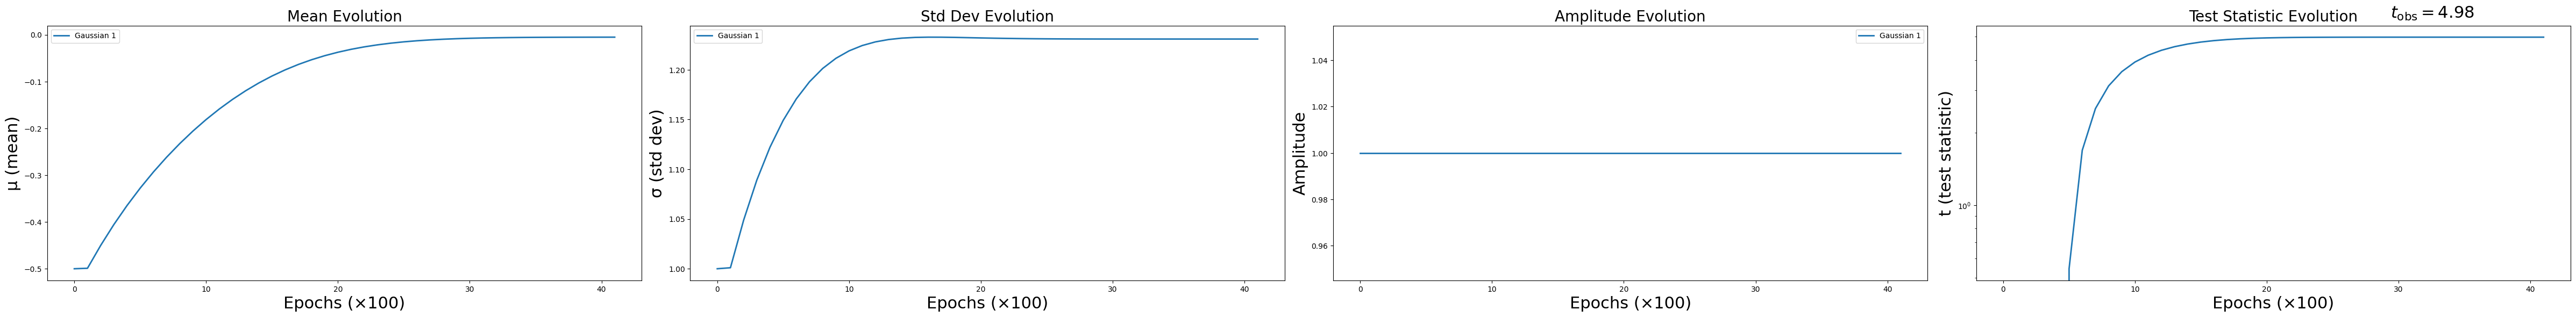

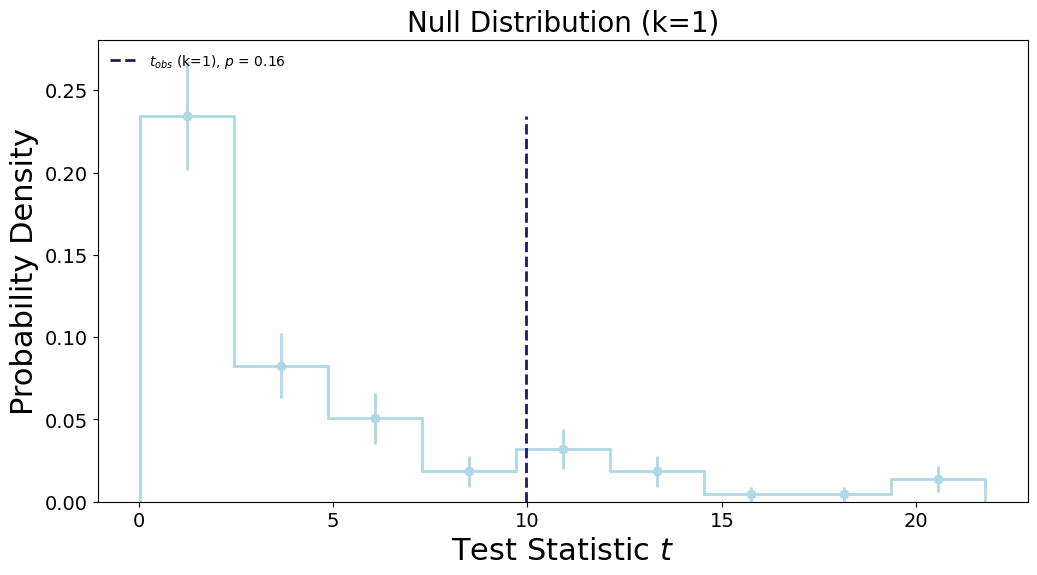

Completed training for k=1 on Alternative 1 (σ=1.2)
  t_obs = 9.957, p-value = 0.160


In [16]:
experiment_results = {}
experiment_results[1] = run_experiment_for_k(
    k=1,
    data=data1,
    data_label='Alternative 1 (σ=1.2)',
    record_every=50,
    include_amplitude=False,
    device=device
)


### 8.2 Case: k = 2

Two components already allow a bimodal structure and can better reproduce the heavier/softer tails of the truth distribution.

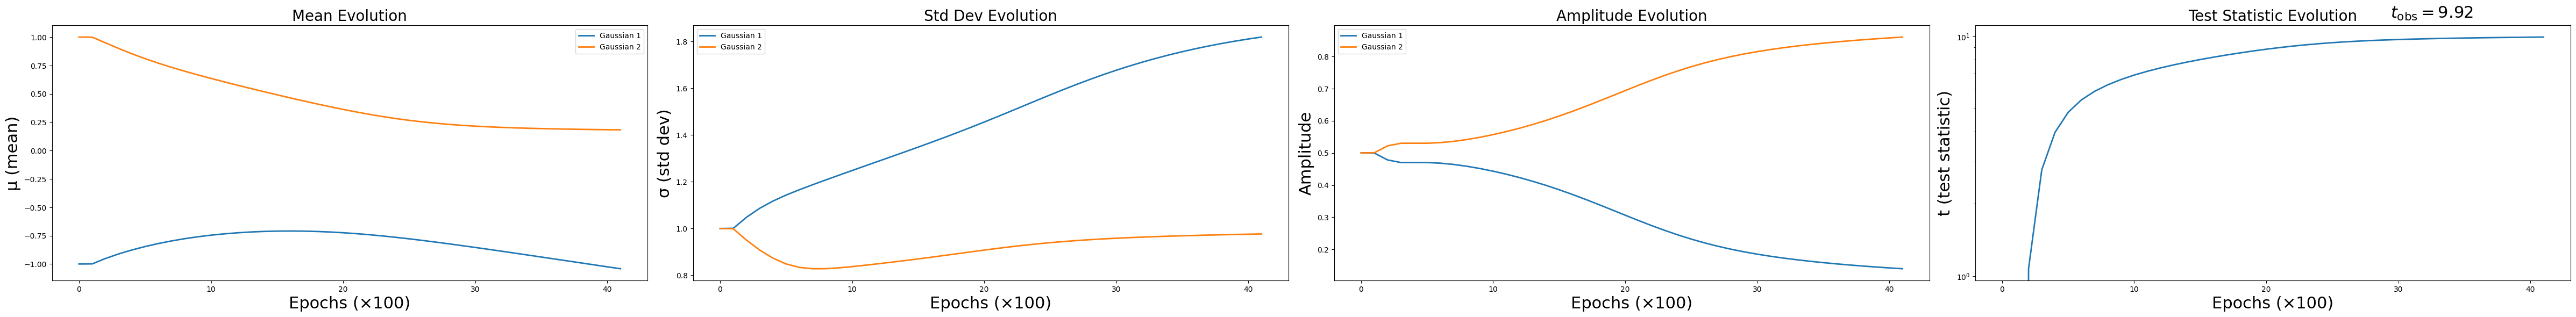

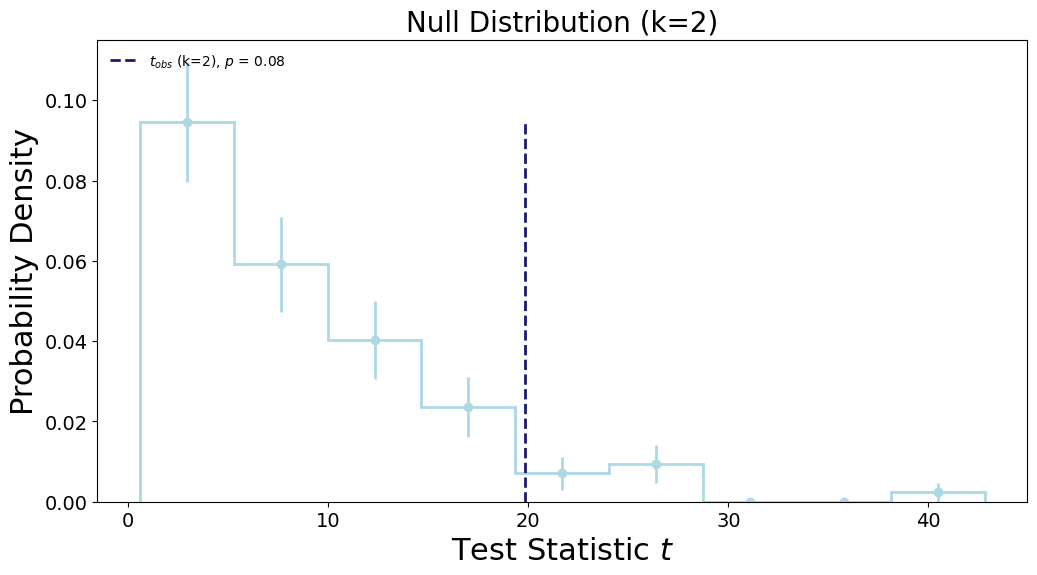

Completed training for k=2 on Alternative 1 (σ=1.2)
  t_obs = 19.846, p-value = 0.080


In [17]:
experiment_results[2] = run_experiment_for_k(
    k=2,
    data=data1,
    data_label='Alternative 1 (σ=1.2)',
    record_every=50,
    include_amplitude=True,
    device=device
)


### 8.3 Case: k = 15

A rich mixture with \(k=15\) can approximate the continuous shape of the alternative almost arbitrarily well, providing a near-saturated alternative hypothesis.

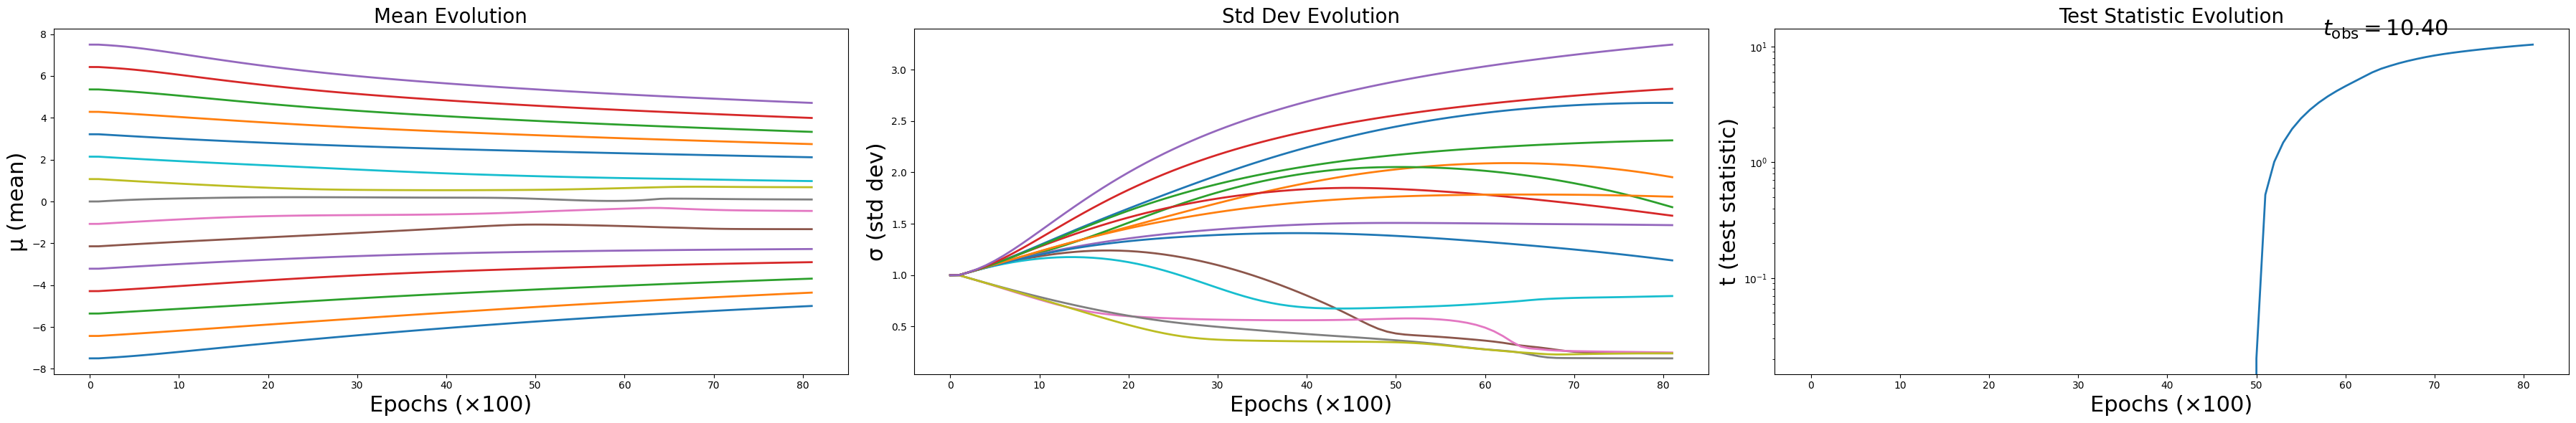

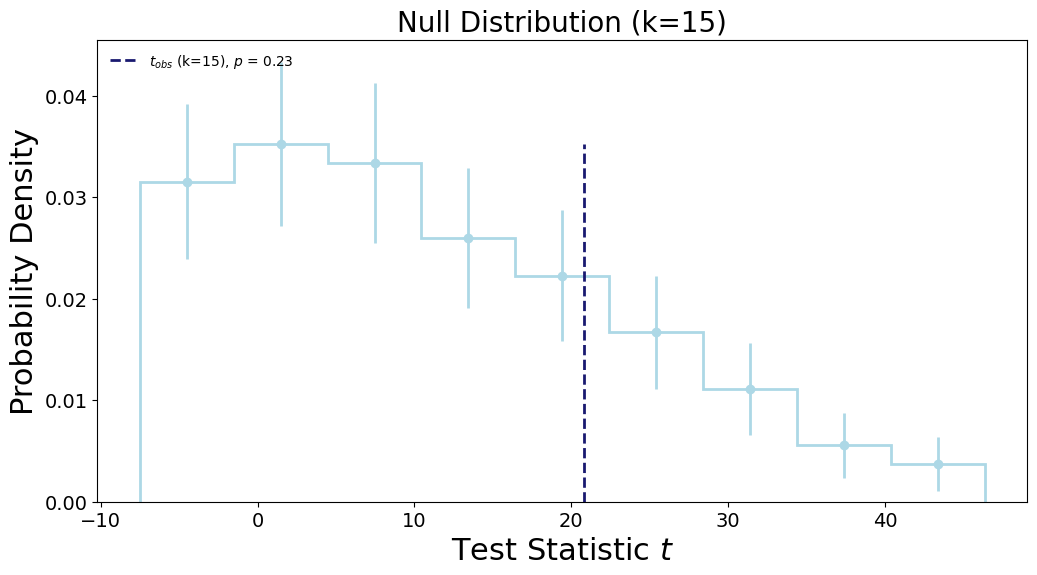

Completed training for k=15 on Alternative 1 (σ=1.2)
  t_obs = 20.793, p-value = 0.230


In [19]:
experiment_results[15] = run_experiment_for_k(
    k=15,
    data=data1,
    data_label='Alternative 1 (σ=1.2)',
    record_every=25,
    include_amplitude=False,
    device=device
)


## 9. Final Comparison Across k

We summarise the observed test statistics, empirical p-values, and overlay the fitted probability density functions for \(k = 1, 2, 15\) against the same dataset.

Summary of test statistics and p-values:
  k= 1 -> t_obs = 9.957, p-value = 0.160
  k= 2 -> t_obs = 19.846, p-value = 0.080
  k=15 -> t_obs = 20.793, p-value = 0.230


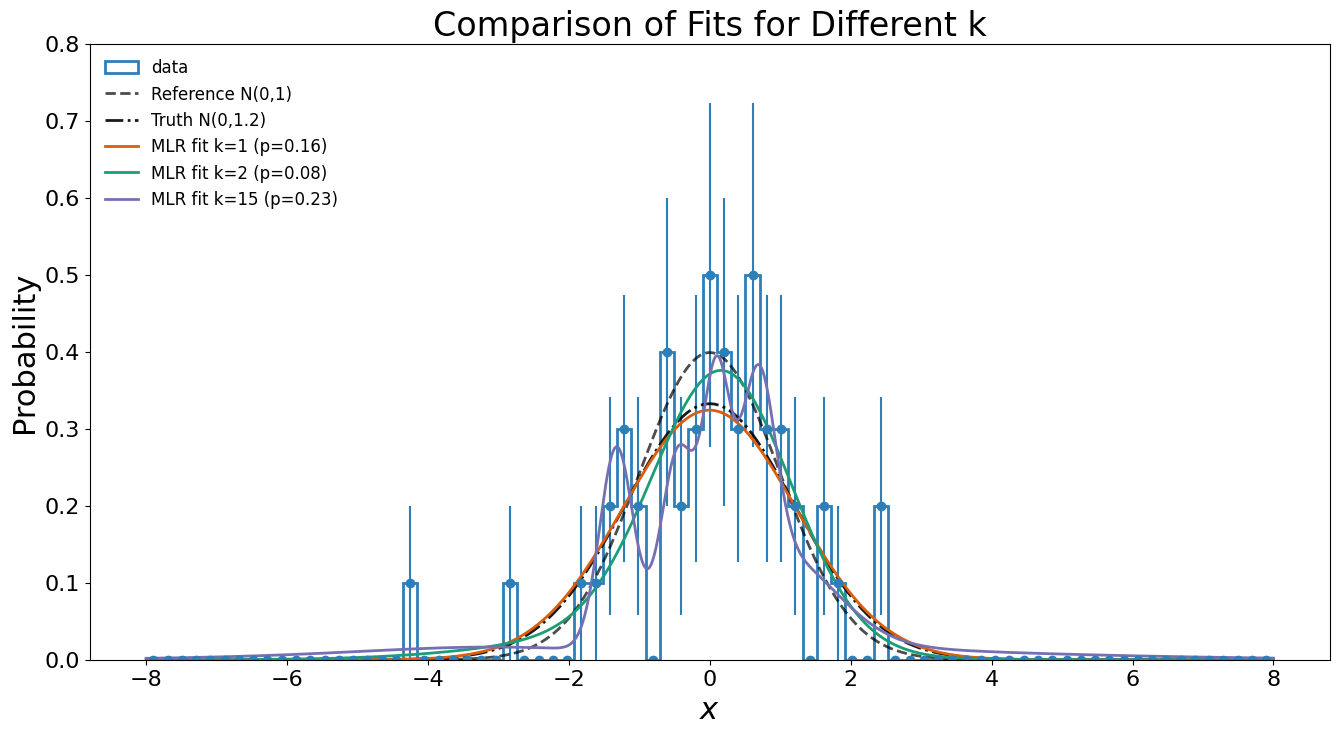

In [20]:
summary_rows = []
for k_val in sorted(experiment_results.keys()):
    res = experiment_results[k_val]
    summary_rows.append(
        {
            'k': k_val,
            't_obs': res['t_obs'],
            'p_value': res['p_value']
        }
    )

print("Summary of test statistics and p-values:")
for row in summary_rows:
    print(f"  k={row['k']:>2} -> t_obs = {row['t_obs']:.3f}, p-value = {row['p_value']:.3f}")

fig = plt.figure(figsize=(16, 8))
fig.patch.set_facecolor('white')

# Histogram of data
xmin, xmax, nbins = -8, 8, 80
bins = np.linspace(xmin, xmax, nbins)
bin_width = (xmax - xmin) / nbins
weights = np.ones(len(data1)) / (len(data1) * bin_width)

h = plt.hist(
    data1,
    bins=bins,
    weights=weights,
    histtype='step',
    color='#2c7fb8',
    lw=2,
    label='data'
)
counts = h[0]
x_centers = 0.5 * (bins[1:] + bins[:-1])
err = np.sqrt(counts / (len(data1) * bin_width))
plt.errorbar(x_centers, counts, yerr=err, color='#2c7fb8', marker='o', ls='', lw=1.5)

x = np.linspace(xmin, xmax, 2000)
plt.plot(x, norm.pdf(x, loc=mu0, scale=std0), 'k--', lw=2, alpha=0.7, label='Reference N(0,1)')
plt.plot(x, norm.pdf(x, loc=mu1, scale=std1), 'k-.', lw=2, alpha=0.9, label='Truth N(0,1.2)')

color_cycle = {1: '#d95f0e', 2: '#1b9e77', 15: '#7570b3'}
for k_val in sorted(experiment_results.keys()):
    res = experiment_results[k_val]
    density = prob_k_gaussian(x, res['mu'], res['sigma'], res['amplitude_logits'])
    label = f"MLR fit k={k_val} (p={res['p_value']:.2f})"
    plt.plot(x, density, color=color_cycle.get(k_val, None), lw=2, label=label)

plt.legend(frameon=False, loc='upper left', fontsize=12)
plt.ylim(0, 0.8)
plt.xlabel(r'$x$', fontsize=22)
plt.ylabel('Probability', fontsize=22)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('Comparison of Fits for Different k', fontsize=24)
plt.show()


# Understand the results and draw conclusions:
### Questions:
Which modeling assupmtions give the best detection results?\
Is this what you expected and why?

### Advanced exercises:
1. **Can you observe similar behaviors changing the hyper-parameters of a classifier-based test statistics?** Try to fit the data with a simple neural network, changing the architecture and rgularization scheme. You can compute a test statistics of your choice on the classifier output.
2. **Try to mitigate the problem of model selection using a multiple test approach.** You can try different way to combine tests, either at the level of the test statistic or at the level of the p-value (see https://arxiv.org/abs/2408.12296 ).